In [1]:
import re
from functools import reduce
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask import dataframe as ddf

plt.rcParams['font.sans-serif'] = ['SimHei']   # Simplified Chinese display
plt.rcParams['axes.unicode_minus'] = False     # sign display

In [2]:
%%time
full = pickle.load(open('/home/new/database/Daily_return_with_cap.pkl', 'rb'))
# TODO: why dask?
portfolio_stock = ddf.read_csv('data/股票投资明细/*', dtype={'Symbol': 'object'}).compute()
fees = ddf.read_csv('data/管理费率/*', dtype={'Symbol': 'object', 'ProportionOfFee': 'object'}, parse_dates=['DeclareDate']).compute()
maininfo = pd.read_csv('data/FUND_MainInfo.csv', parse_dates=['InceptionDate'])
unitclassinfo = pd.read_csv('data/FUND_UnitClassInfo.csv', parse_dates=['ListingDate'])
fund_dividend = pd.read_csv('data/Fund_FundDividend.csv', parse_dates=['PrimaryExDividendDate', 'SecondaryExDividendDate'])
nav_month = pd.read_csv('data/Fund_NAV_Month.csv', parse_dates=['TradingDate'])
mkt_month = pd.read_csv('data/Fund_MKInfoStaMonth.csv', parse_dates=['SgnMonth'], index_col=0)
# TODO: time span not aligned
resolution = pd.read_csv('data/Fund_Resolution.csv', parse_dates=['DeclareDate'])

CPU times: total: 4.48 s
Wall time: 6.1 s


## I. Preliminary

（1）基金类别必须为“股票型基金”或“混合型基金”；

（2）非 ETF 类基金；

（3）非 QDII 类基金；

（4）主动管理标识为 1 或者为空；

（5）基金上市时间超过一年；

（6）最近一次年报或半年报披露的中国市场股票持股比例超过总管理规模的 30%

In [3]:
%%time

# (1)
# Category [基金类别] - 股票型基金；债券型基金；货币型基金；混合型基金；FOF；股指期货型基金；其他
# TODO: why duplicated?
# ? duplicated MasterFundCode with different actual name
# check with `maininfo.loc[condition_1[condition_1.duplicated(keep=False)].index]`
condition_1 = maininfo[np.logical_or(maininfo.Category == '股票型基金', maininfo.Category == '混合型基金')].MasterFundCode.unique()

# (2)
# IsETF [是否ETF] - 1=是；2=否
condition_2 = maininfo[maininfo.IsETF == 2].MasterFundCode.unique()

# (3)
# IsQDII [是否QDII] - 1=是；2=否
condition_3 = maininfo[maininfo.IsQDII == 2].MasterFundCode.unique()

# (4)
# IsActiveOrPassive [主动标识] - 1=主动；2=被动
condition_4 = maininfo[maininfo.IsActiveOrPassive != 2].MasterFundCode.unique()

# (5)
# TODO: `上市日期` or `发行日期`
# TODO: 3 steps

# * `上市日期` 超过1年
# note, `MasterFundCode` in `unitclassinfo` is `Symbol` column
condition_5_ = unitclassinfo[(pd.Timestamp.now() - unitclassinfo.ListingDate).apply(lambda timedelta: timedelta.days>365)].Symbol.unique()
# len(condition_5_) -> 703

# * `发行日期` 超过1年
condition_5__ = maininfo[(pd.Timestamp.now() - maininfo.InceptionDate).apply(lambda timedelta: timedelta.days>365)].MasterFundCode.unique()
# len(condition_5__) -> 2782

# * `上市日期` 或 `发行日期` 超过1年
condition_5 = np.array(list(set(np.concatenate([condition_5_, condition_5__]))))
# len(condition_5) -> 3122


# (6)
# ! CSMAR do not have `mainland && stock in portfolio proportion` data, we have to calculate it manually
# ! the most similar data is `areaclass`, but only cover 170 funds
# areaclass = pd.read_csv('data/FUND_AREACLASS.csv')
# print(len(areaclass.groupby('MasterFundCode').apply(lambda x: 0)))

# ReportTypeID [定期报告类别编码] - 1－第一季度；2－第二季度；3－第三季度；4－第四季度；5－半年度；6－年度；7－其他周期
# Startdate [开始日期] - 
# EndDate [截止日期] - 
# InvestmentType [投资类型分类] - 1=积极投资； 2=指数投资；3=综合；4=新股型。
# Rank [排名]
# Symbol [股票代码]
# StockName [股票名称]
# Proportion [占净值比例(%)]

# TODO: Symbol v.s. MasterFundCode
# TODO: how many mutual funds total?
# TODO: why `len(condition_6)` so small?
# filter the last report period
last_report_period_portfolio_stock = portfolio_stock.groupby('MasterFundCode')\
    .apply(lambda one_code: one_code[one_code.EndDate == one_code.EndDate.iloc[-1]])\
        .set_index('MasterFundCode')

portfolio_stock_ = last_report_period_portfolio_stock


# filter China mainland stock
mainland_code = '6\d{5}|9\d{5}|0\d{5}|2\d{5}|3\d{5}|8\d{5}|4\d{5}'
last_report_period_portfolio_mainland_stock = portfolio_stock_[\
    portfolio_stock_.Symbol.apply(lambda code: True if re.match(mainland_code, code) else False)]

portfolio_stock__ = last_report_period_portfolio_mainland_stock

# ! 576 annual report only
# code_series = portfolio_stock__.groupby(level=0)\
#     .apply(lambda one_code: True if one_code[one_code.ReportTypeID == 6].Proportion.sum() > .3 else False)

# sum annual report proportion and compare with 30%
code_series = portfolio_stock__.groupby(level=0)\
    .apply(lambda one_code: True if one_code[\
        np.logical_or(one_code.ReportTypeID == 6, one_code.ReportTypeID == 5)]\
            .Proportion.sum() > .3 else False)

condition_6 = code_series[code_series].index.values

len(condition_1), len(condition_2), len(condition_3), len(condition_4), len(condition_5), len(condition_6)

CPU times: total: 7.7 s
Wall time: 8.1 s


(7122, 10589, 11136, 9452, 10025, 6877)

In [4]:
fund_codes = reduce(np.intersect1d, [condition_1, condition_2, condition_3, condition_4, condition_5, condition_6])
fund_codes, len(fund_codes)

(array([     6,     11,     17, ..., 970043, 970048, 970068], dtype=int64),
 4411)

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*SF_t}{NAV_{t-1}*SF_{t-1}}
$$

$NAV_t$ 基金在 $t$ 月末的基金净值

$Div_t$ 在 $t$ 月中发放的现金分红

$SF_t$ 累计拆分因子

In [5]:
%%time

# TODO: 872018, 872020 not in `fund_dividend` but in `fund_codes`
# maininfo[maininfo.MasterFundCode == 872020]
# fund_dividend[fund_dividend.Symbol == 872020]

# * ------------ NAV_t+Div_t start ------------

ExDividendDate = fund_dividend.PrimaryExDividendDate.dt.strftime('%Y-%m').copy()
ExDividendDate.name = 'ExDividendMonth'
ExDividendDate[ExDividendDate.isnull()] = fund_dividend.SecondaryExDividendDate[ExDividendDate.isnull()].dt.strftime('%Y-%m').copy()

# * dividend paied multiple times in one month
# check with
# `fund_dividend.groupby(['Symbol', ExDividendDate]).apply(lambda one_month: print(one_month) if len(one_month) != 1 else one_month.DividendperShare.sum())`
dividend = fund_dividend.groupby(['Symbol', ExDividendDate]).apply(lambda one_month: one_month.DividendperShare.sum())

nav = nav_month.copy().set_index(['Symbol', 'TradingMonth']).NAV
co_time = np.intersect1d(dividend.index, nav.index)

dividend_adj_nav = nav.copy()
dividend_adj_nav.loc[co_time] += dividend.loc[co_time] / 10

# * ------------ NAV_t+Div_t end ------------



# * ------------ (NAV_t+Div_t)*SF_t start ------------

split = resolution.set_index(['Symbol', resolution.DeclareDate.dt.strftime('%Y-%m')]).copy().SplitRatio

# * split multiple times in one month
# check with `split[split.index.duplicated(keep=False)]`
split = split.groupby(level=[0, 1]).apply(sum)

# ? after the end of net value record, split may happens
# check with
# np.setdiff1d(split.index, dividend_adj_nav.index)
# dividend_adj_nav.unstack(0)[162109].plot()
# dividend_adj_nav.unstack(0)[184689].plot()
# ...
split = split.drop(np.setdiff1d(split.index, dividend_adj_nav.index))

dividend_adj_nav.loc[split.index] *= split

# * ------------ (NAV_t+Div_t)*SF_t end ------------



# * ------------ R_t^{real} ------------

nav.loc[split.index] *= split

r_t_real = dividend_adj_nav.unstack(0) / nav.unstack(0).shift(1)
print(r_t_real.shape)

# specify funds we use
# ! in case: 872018, 872020 not in `fund_dividend` but in `fund_codes`
# r_t_real = r_t_real[fund_codes]

r_t_real = r_t_real[np.intersect1d(r_t_real.columns, fund_codes)]
print(r_t_real.shape)

# * ------------ R_t^{real} ------------

(248, 18917)
(248, 4409)
CPU times: total: 56.8 s
Wall time: 59.3 s


Additional

(7) Check

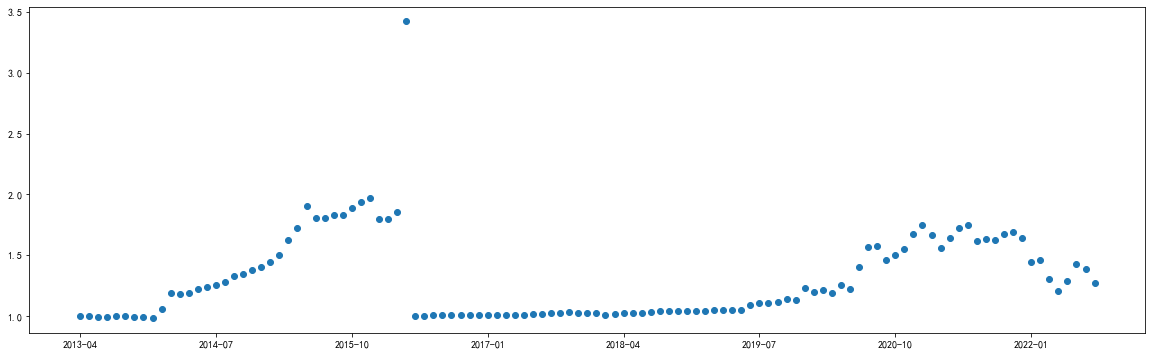

In [6]:

# TODO: why 1.4?
possible_errors = r_t_real.columns[(np.abs(r_t_real) > 1.4).any()]

plt.figure(figsize=(20,6))
this_code_nav = nav[nav.index.get_level_values(0) == possible_errors[0]]
plt.scatter(this_code_nav.index.get_level_values(1), this_code_nav.values)
plt.xticks(this_code_nav.index.get_level_values(1)[::15])
pass

In [7]:
r_t_real_ = r_t_real.drop(possible_errors, axis=1)
pass

In [8]:
stock_fund = np.intersect1d(maininfo[maininfo.Category == '股票型基金'].MasterFundCode.unique(), fund_codes)
integrated_fund = np.intersect1d(maininfo[maininfo.Category == '混合型基金'].MasterFundCode.unique(), fund_codes)

# TODO: in case use full range funds
# stock_fund = maininfo[maininfo.Category == '股票型基金'].MasterFundCode.unique()
# integrated_fund = maininfo[maininfo.Category == '混合型基金'].MasterFundCode.unique()

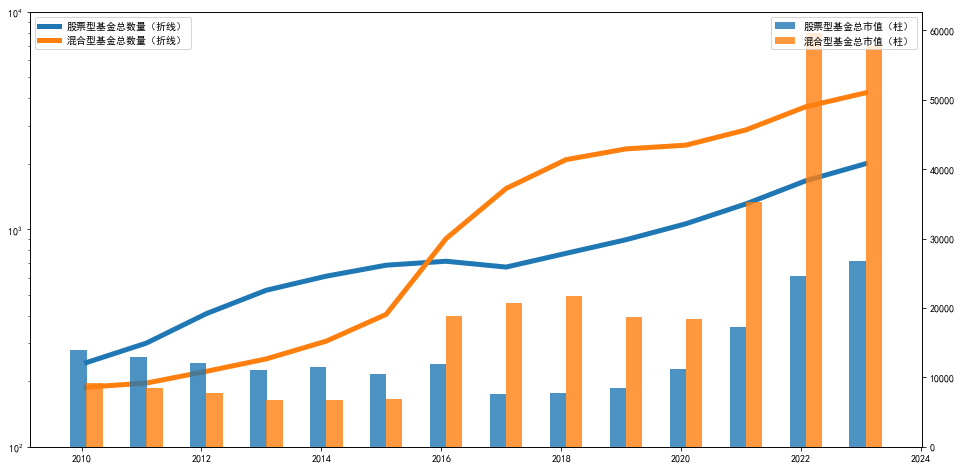

In [9]:
# SgnMonth [统计月份] - null
# CategoryID [基金类型编号] - 0:全部基金;1:股票型基金;2:债券型基金;3:货币型基金;4:混合型基金;5:FOF;6:商品期货型基金;7:REITs;8:其他;21:封闭式基金;22:开放式基金;31:场内基金;32:场外基金;40:ETF基金;50:LOF基金
# TotalFundNAV [基金总资产净值] - 对应类型的所有基金的总资产净值

# TODO: 不一致

stock_mkt_month = mkt_month[mkt_month.CategoryID == 1].resample('12M').mean()
mixed_mkt_month = mkt_month[mkt_month.CategoryID == 4].resample('12M').mean()
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(16)
ax1.plot(stock_mkt_month.FundNum, linewidth=5, label='股票型基金总数量（折线）')
ax1.plot(mixed_mkt_month.FundNum, linewidth=5, label='混合型基金总数量（折线）')
ax1.set_yscale('log')
ax1.set_yticks([100, 1000, 10000])

ax2 = ax1.twinx()
ax2.bar(stock_mkt_month.index - pd.Timedelta('7W'), stock_mkt_month.TotalFundNAV.values, width=100 ,label='股票型基金总市值（柱状）', alpha=.8)
ax2.bar(mixed_mkt_month.index + pd.Timedelta('7W'), mixed_mkt_month.TotalFundNAV.values, width=100 ,label='混合型基金总市值（柱状）', alpha=.8)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

Text(0.5, 1.0, '「所有」基金管理费率日平均（柱状）/季度平均（折线）')

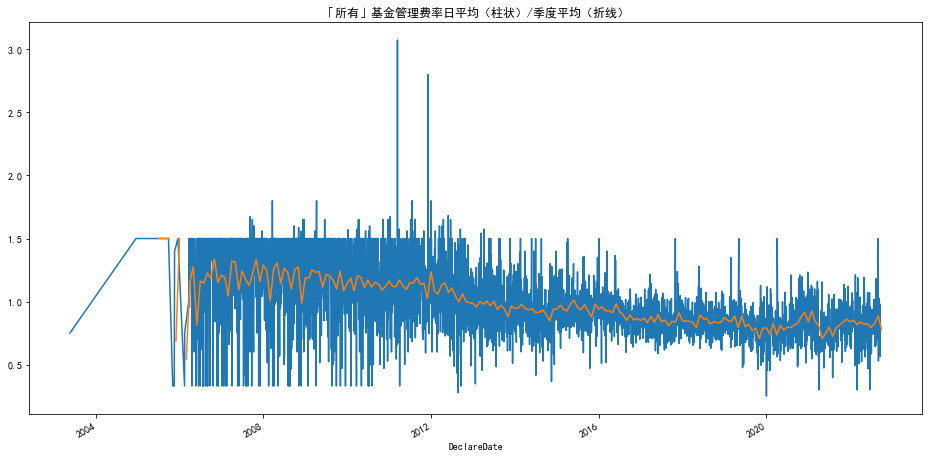

In [12]:
management_fee = fees[fees.NameOfFee == '管理费率']
# TODO: minimal subscription written to management fee
# management_fee[management_fee.ProportionOfFee.astype(float) == 1000]
management_fee_ = management_fee[management_fee.ProportionOfFee.astype(float) != 1000]

# smallest date interval
management_fee__ = management_fee_.groupby('DeclareDate').apply(lambda one_date: one_date.ProportionOfFee.astype(float).mean())
plt.figure(figsize=(16,8))
management_fee__.plot()
management_fee__.resample('1M').mean().plot()
plt.title('「所有」基金管理费率日平均（柱状）/季度平均（折线）')
# TODO: 国泰安数据不全，2006前数据缺失
# TODO: 不一致

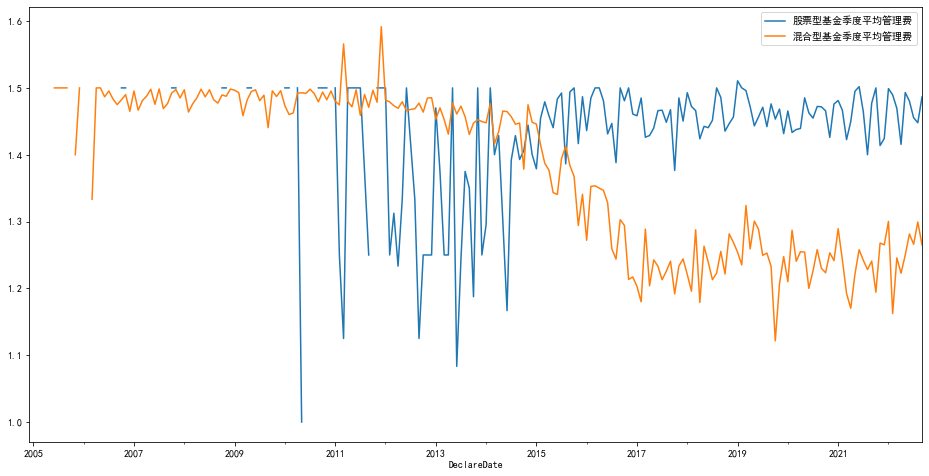

In [11]:
management_fee_stock_fund = management_fee_.groupby('Symbol').apply(\
    lambda one_fund: one_fund if float(one_fund.Symbol.unique()[0]) in stock_fund else None)
    
management_fee_integrated_fund = management_fee_.groupby('Symbol').apply(\
    lambda one_fund: one_fund if float(one_fund.Symbol.unique()[0]) in integrated_fund else None)

management_fee_stock_fund_ = management_fee_stock_fund.groupby('DeclareDate').apply(\
    lambda one_date: one_date.ProportionOfFee.astype(float).mean())
management_fee_integrated_fund_ = management_fee_integrated_fund.groupby('DeclareDate').apply(\
    lambda one_date: one_date.ProportionOfFee.astype(float).mean())

plt.figure(figsize=(16,8))
management_fee_stock_fund_.resample('1M').mean().plot(label='股票型基金季度平均管理费')
management_fee_integrated_fund_.resample('1M').mean().plot(label='混合型基金季度平均管理费')
plt.legend()

## II.Select

月末等权重买入一种分类中所有基金

持有一个月，按月滚动调整

**?等金额权重/等份额权重**

In [ ]:
stock_avg_change = full.pivot(index='TRADE_DT', columns='S_INFO_WINDCODE', values='S_DQ_CLOSE').pct_change()\
    .apply(lambda date: date.sum()/pd.notnull(date).sum() if date.sum() != 0 else None, axis=1)\
        .loc['2002-1-1':'2022-9-22']')

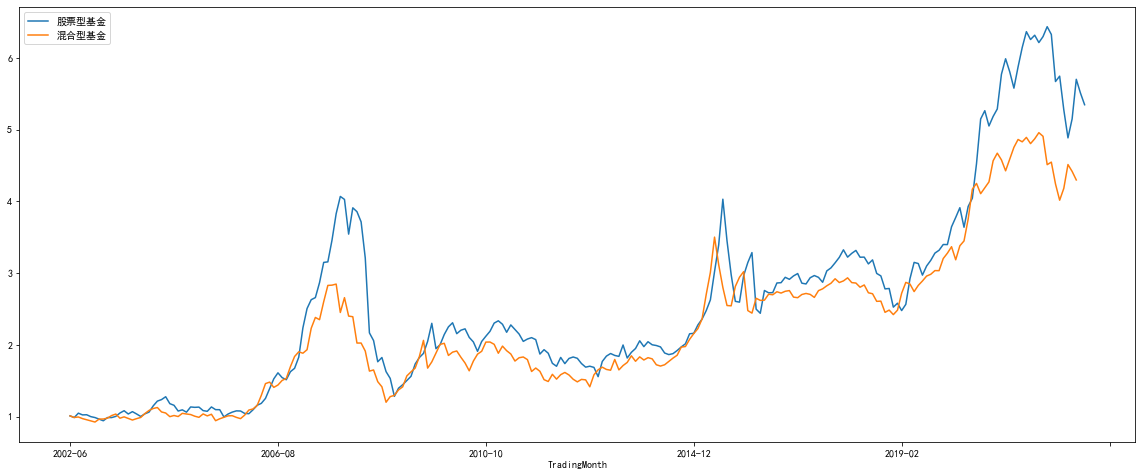

In [33]:
# 等份额权重
# remove all null month
# TODO, probable cause: funds listed before 2022-04 did not meet other requirements

plt.figure(figsize=(20,8))
stock_r_t = r_t_real_[np.intersect1d(stock_fund, r_t_real_.columns)]
stock_r_t_ = stock_r_t[~ pd.isnull(stock_r_t).all(axis=1)]
stock_r_t_.apply(lambda one_month: one_month.sum()/pd.notnull(one_month).sum(), axis=1).cumprod().plot(label='股票型基金')
mixed_r_t = r_t_real_[np.intersect1d(integrated_fund, r_t_real_.columns)]
mixed_r_t_ = mixed_r_t[~ pd.isnull(mixed_r_t).all(axis=1)]
mixed_r_t_.apply(lambda one_month: one_month.sum()/pd.notnull(one_month).sum(), axis=1).cumprod().plot(label='混合型基金')
(stock_avg_change + 1).resample('3M').mean().cumprod().plot(label='股票市场组合')
plt.legend()